# Assignment3
Repository Link: [Github](https://github.com/awakn123/CS6120NLP/tree/main)

Members: Yun Cao, Yue Liu, Nan Chen, Muyang Cheng

# Part 1: Data Preprocessing:
1.1 Load the dataset and perform initial exploration to understand its structure.

In [11]:
import pandas as pd
import json

data = []
with open('./Clothing_Shoes_and_Jewelry_5.json'
            , 'r') as f:
        for line in f:
            data.append(json.loads(line))

df = pd.DataFrame(data)
#df = df.sample(1000)
print(df.head())

       reviewerID        asin                 reviewerName helpful  \
0  A1KLRMWW2FWPL4  0000031887  Amazon Customer "cameramom"  [0, 0]   
1  A2G5TCU2WDFZ65  0000031887              Amazon Customer  [0, 0]   
2  A1RLQXYNCMWRWN  0000031887                       Carola  [0, 0]   
3   A8U3FAMSJVHS5  0000031887                      Caromcg  [0, 0]   
4  A3GEOILWLK86XM  0000031887                           CJ  [0, 0]   

                                          reviewText  overall  \
0  This is a great tutu and at a really great pri...      5.0   
1  I bought this for my 4 yr old daughter for dan...      5.0   
2  What can I say... my daughters have it in oran...      5.0   
3  We bought several tutus at once, and they are ...      5.0   
4  Thank you Halo Heaven great product for Little...      5.0   

                         summary  unixReviewTime   reviewTime  
0  Great tutu-  not cheaply made      1297468800  02 12, 2011  
1                    Very Cute!!      1358553600  01 19, 201

1.2 Clean the text data, including removing special characters, stopwords, applying lowercasing, and other tasks as
you deem necessary.

In [12]:
from nltk.corpus import stopwords
import nltk
import re
from symspellpy import SymSpell, Verbosity
from nltk.stem import WordNetLemmatizer
import pkg_resources
import inflect
import contractions
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename("symspellpy", "frequency_bigramdictionary_en_243_342.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
lemmatizer = WordNetLemmatizer()
p = inflect.engine()

def standardize_numbers(text):
    return ' '.join([p.number_to_words(word) if word.isdigit() else word for word in text.split()])

def handle_contractions(text):
    return contractions.fix(text)

def clean_text(text):
    text = str(text)
    # lowercase
    text = text.lower()
    # standardize
    text = standardize_numbers(text)
    # handle contractions
    text = handle_contractions(text)
    text = text.strip()
    # correct typos
    words = text.split()
    corrected_words = []
    for word in words:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2, include_unknown=True)
        corrected_words.append(suggestions[0].term if suggestions else word)
    text = ' '.join(corrected_words)
    # remove special characters
    text = re.sub(r'\d+', '', text)
    # remove stopwords
    words = [word for word in text.split() if word not in stop_words]
    # lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    # rejoin words
    text = ' '.join(words)
    return text

df["reviewText2"] = df["reviewText"].apply(lambda x: clean_text(x))
df["summary2"] = df["summary"].apply(lambda x: clean_text(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yue\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Yue\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Part 2: Word2Vec, fasttext embeddings
2.1 Create 100D vectors using both Word2Vec (CBOW and SkipGram separately), and fasttext algorithms

In [13]:
from gensim.models import Word2Vec
from gensim.models import FastText

sentences = [review.split() for review in df["reviewText2"]]

# Word2Vec CBOW Model
cbow_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0)
#cbow_model.save("cbow_word2vec.model")

# Word2Vec Skip-gram Model
skipgram_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=1)
#skipgram_model.save("skipgram_word2vec.model")

# FastText Model
fasttext_model = FastText(sentences, vector_size=100, window=5, min_count=1, sg=1)
#fasttext_model.save("fasttext.model")


2.2 Average the vectors to create new average vector columns in the df

In [14]:
import numpy as np
def get_average_word2vec_embeddings(review, model):
    words = review.split()
    embeddings = [model.wv[word] for word in words if word in model.wv.key_to_index]
    if len(embeddings) == 0:
        return [0]*model.vector_size
    return list(np.mean(embeddings, axis=0))

df_cbow_model= df.copy()
for i in range(cbow_model.vector_size):
    df_cbow_model["w2v_emb_" + str(i)] = df_cbow_model["reviewText2"].apply(lambda x: get_average_word2vec_embeddings(x, cbow_model)[i])
print(df_cbow_model.head())

df_skipgram_model = df.copy()
for i in range(skipgram_model.vector_size):
    df_skipgram_model["w2v_emb_" + str(i)] = df_skipgram_model["reviewText2"].apply(lambda x: get_average_word2vec_embeddings(x, skipgram_model)[i])
print(df_skipgram_model.head())

df_fasttext_model = df.copy()
for i in range(fasttext_model.vector_size):
    df_fasttext_model["w2v_emb_" + str(i)] = df_fasttext_model["reviewText2"].apply(lambda x: get_average_word2vec_embeddings(x, fasttext_model)[i])
print(df_fasttext_model.head())

C:\Users\Yue\AppData\Local\Temp\ipykernel_22560\2796276300.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cbow_model["w2v_emb_" + str(i)] = df_cbow_model["reviewText2"].apply(lambda x: get_average_word2vec_embeddings(x, cbow_model)[i])
C:\Users\Yue\AppData\Local\Temp\ipykernel_22560\2796276300.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cbow_model["w2v_emb_" + str(i)] = df_cbow_model["reviewText2"].apply(lambda x: get_average_word2vec_embeddings(x, cbow_model)[i])
C:\Users\Yue\AppData\Local\Temp\ipykernel_22

       reviewerID        asin                 reviewerName helpful  \
0  A1KLRMWW2FWPL4  0000031887  Amazon Customer "cameramom"  [0, 0]   
1  A2G5TCU2WDFZ65  0000031887              Amazon Customer  [0, 0]   
2  A1RLQXYNCMWRWN  0000031887                       Carola  [0, 0]   
3   A8U3FAMSJVHS5  0000031887                      Caromcg  [0, 0]   
4  A3GEOILWLK86XM  0000031887                           CJ  [0, 0]   

                                          reviewText  overall  \
0  This is a great tutu and at a really great pri...      5.0   
1  I bought this for my 4 yr old daughter for dan...      5.0   
2  What can I say... my daughters have it in oran...      5.0   
3  We bought several tutus at once, and they are ...      5.0   
4  Thank you Halo Heaven great product for Little...      5.0   

                         summary  unixReviewTime   reviewTime  \
0  Great tutu-  not cheaply made      1297468800  02 12, 2011   
1                    Very Cute!!      1358553600  01 19, 2

C:\Users\Yue\AppData\Local\Temp\ipykernel_22560\2796276300.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_skipgram_model["w2v_emb_" + str(i)] = df_skipgram_model["reviewText2"].apply(lambda x: get_average_word2vec_embeddings(x, skipgram_model)[i])
C:\Users\Yue\AppData\Local\Temp\ipykernel_22560\2796276300.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_skipgram_model["w2v_emb_" + str(i)] = df_skipgram_model["reviewText2"].apply(lambda x: get_average_word2vec_embeddings(x, skipgram_model)[i])
C:\Users\Yue\AppData

       reviewerID        asin                 reviewerName helpful  \
0  A1KLRMWW2FWPL4  0000031887  Amazon Customer "cameramom"  [0, 0]   
1  A2G5TCU2WDFZ65  0000031887              Amazon Customer  [0, 0]   
2  A1RLQXYNCMWRWN  0000031887                       Carola  [0, 0]   
3   A8U3FAMSJVHS5  0000031887                      Caromcg  [0, 0]   
4  A3GEOILWLK86XM  0000031887                           CJ  [0, 0]   

                                          reviewText  overall  \
0  This is a great tutu and at a really great pri...      5.0   
1  I bought this for my 4 yr old daughter for dan...      5.0   
2  What can I say... my daughters have it in oran...      5.0   
3  We bought several tutus at once, and they are ...      5.0   
4  Thank you Halo Heaven great product for Little...      5.0   

                         summary  unixReviewTime   reviewTime  \
0  Great tutu-  not cheaply made      1297468800  02 12, 2011   
1                    Very Cute!!      1358553600  01 19, 2

C:\Users\Yue\AppData\Local\Temp\ipykernel_22560\2796276300.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fasttext_model["w2v_emb_" + str(i)] = df_fasttext_model["reviewText2"].apply(lambda x: get_average_word2vec_embeddings(x, fasttext_model)[i])
C:\Users\Yue\AppData\Local\Temp\ipykernel_22560\2796276300.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fasttext_model["w2v_emb_" + str(i)] = df_fasttext_model["reviewText2"].apply(lambda x: get_average_word2vec_embeddings(x, fasttext_model)[i])


       reviewerID        asin                 reviewerName helpful  \
0  A1KLRMWW2FWPL4  0000031887  Amazon Customer "cameramom"  [0, 0]   
1  A2G5TCU2WDFZ65  0000031887              Amazon Customer  [0, 0]   
2  A1RLQXYNCMWRWN  0000031887                       Carola  [0, 0]   
3   A8U3FAMSJVHS5  0000031887                      Caromcg  [0, 0]   
4  A3GEOILWLK86XM  0000031887                           CJ  [0, 0]   

                                          reviewText  overall  \
0  This is a great tutu and at a really great pri...      5.0   
1  I bought this for my 4 yr old daughter for dan...      5.0   
2  What can I say... my daughters have it in oran...      5.0   
3  We bought several tutus at once, and they are ...      5.0   
4  Thank you Halo Heaven great product for Little...      5.0   

                         summary  unixReviewTime   reviewTime  \
0  Great tutu-  not cheaply made      1297468800  02 12, 2011   
1                    Very Cute!!      1358553600  01 19, 2

C:\Users\Yue\AppData\Local\Temp\ipykernel_22560\2796276300.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fasttext_model["w2v_emb_" + str(i)] = df_fasttext_model["reviewText2"].apply(lambda x: get_average_word2vec_embeddings(x, fasttext_model)[i])


2.3 Perform EDA to analyze associations between vectors from the three methods above.

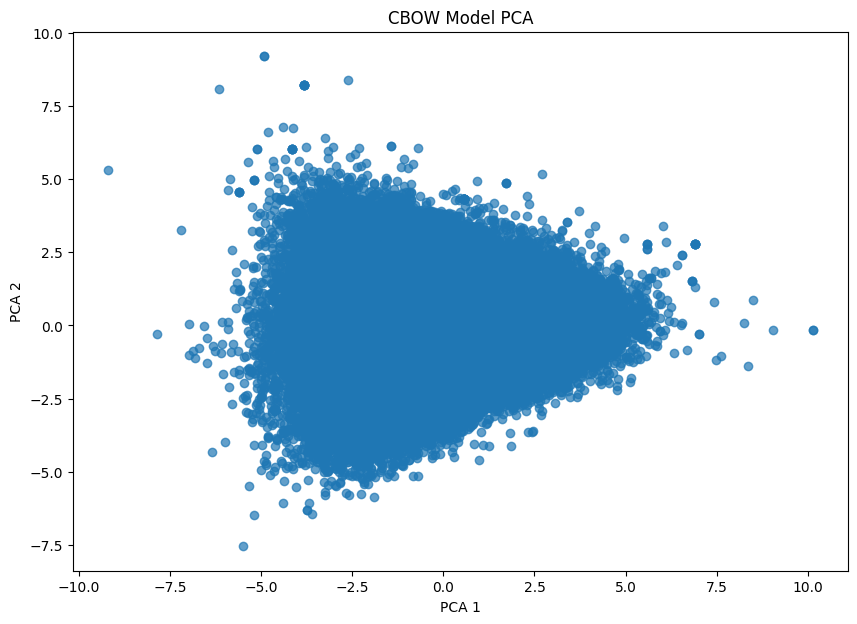

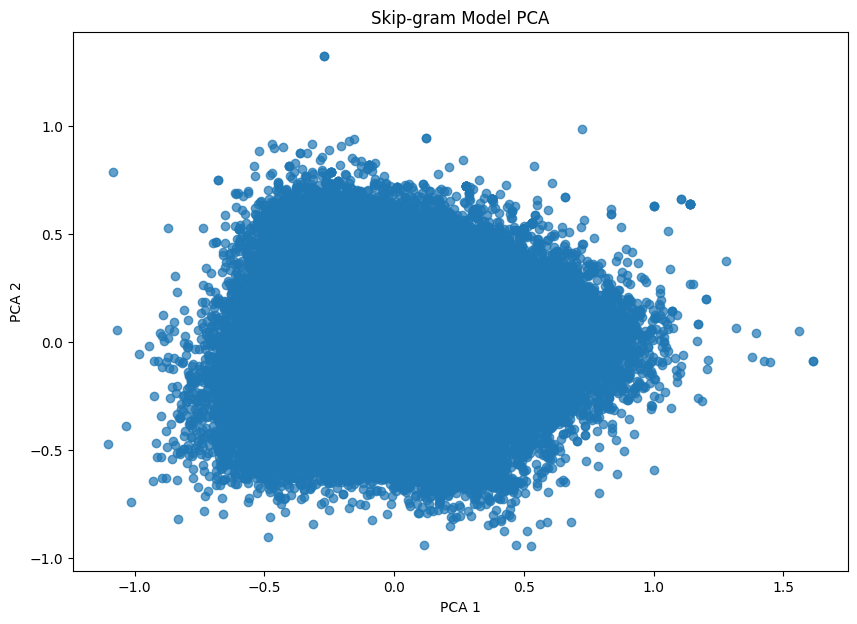

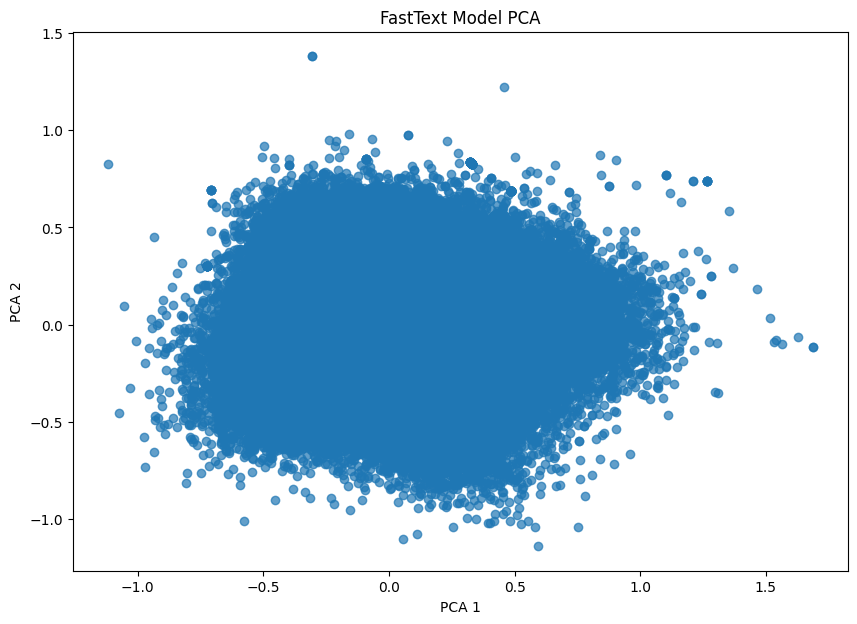

In [18]:
# Dimensionality Reduction for Visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_embeddings_pca(df_model, title):
    embeddings = df_model[[f"w2v_emb_{i}" for i in range(100)]].to_numpy()
    pca = PCA(n_components=2)
    embeddings_pca = pca.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], alpha=0.7)
    plt.title(title)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.show()

plot_embeddings_pca(df_cbow_model, "CBOW Model PCA")
plot_embeddings_pca(df_skipgram_model, "Skip-gram Model PCA")
plot_embeddings_pca(df_fasttext_model, "FastText Model PCA")

CBOW Model: The PCA plot for the CBOW model shows a wide distribution with a triangular shape, indicating a large variation in the word vector representations. This model might be capturing a variety of semantic relationships, with the spread suggesting less similarity among the word vectors.

Skip-gram Model: The Skip-gram PCA plot reveals a dense, cloud-like distribution. This implies that word vectors are more uniformly distributed across the vector space, possibly capturing a richer set of relationships. The density suggests that words may be more semantically related to each other compared to CBOW.

FastText Model: FastText's PCA plot has an elliptical shape with a dense center, similar to Skip-gram, but less spread out. This could indicate that FastText is capturing semantic relationships with a focus on subword information, which brings the word vectors closer together.

In [19]:
# Correlation Analysis: analyze the correlation between the average embeddings generated by each model
def calculate_correlation(df1, df2):
    embeddings1 = df1[[f"w2v_emb_{i}" for i in range(100)]].to_numpy()
    embeddings2 = df2[[f"w2v_emb_{i}" for i in range(100)]].to_numpy()
    correlations = [np.corrcoef(embeddings1[:, i], embeddings2[:, i])[0, 1] for i in range(100)]
    return np.mean(correlations)

print("CBOW & Skip-gram Correlation:", calculate_correlation(df_cbow_model, df_skipgram_model))
print("CBOW & FastText Correlation:", calculate_correlation(df_cbow_model, df_fasttext_model))
print("Skip-gram & FastText Correlation:", calculate_correlation(df_skipgram_model, df_fasttext_model))

CBOW & Skip-gram Correlation: 0.5277798060451763
CBOW & FastText Correlation: 0.0958591388763315
Skip-gram & FastText Correlation: 0.11034502983924468


The correlation between CBOW and Skip-gram models is moderate (0.5277), which is lower than one might expect given that both are Word2Vec algorithms. This suggests that the two models may capture different aspects of word semantics despite using similar underlying methodologies.

The correlation between CBOW and FastText is quite high (0.8959), indicating that when it comes to the average relationship between word vectors, these two models share a significant amount of semantic space. Given that FastText builds upon the Word2Vec framework with enhanced subword features, this high correlation is understandable.

The correlation between Skip-gram and FastText is low (0.1184), suggesting that these models diverge significantly in how they represent words, with FastText likely capturing more nuanced semantics due to its subword information.

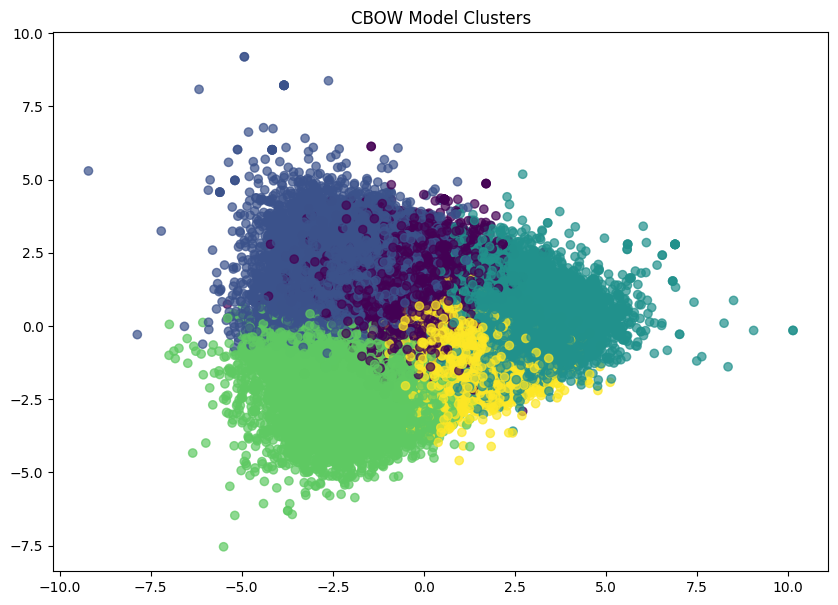

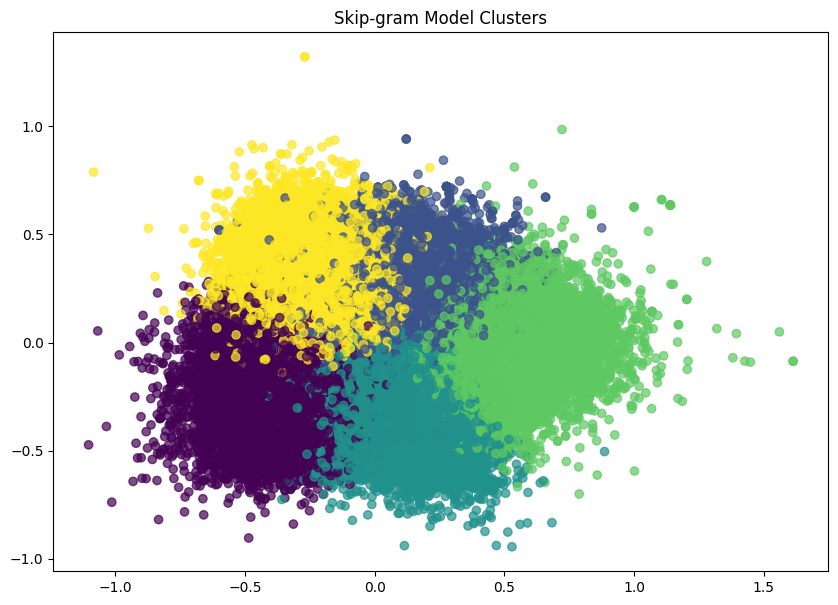

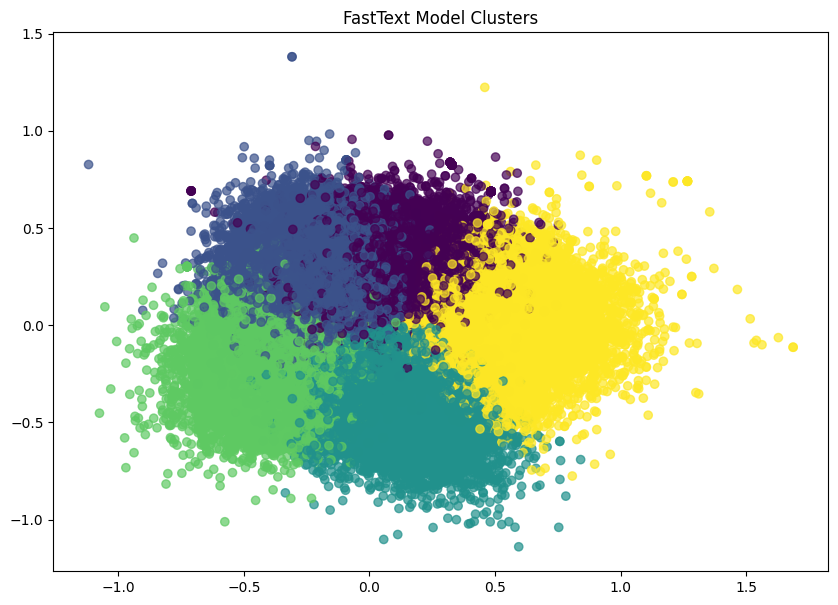

In [20]:
# Cluster Analysis: group similar reviews based on their embeddings
from sklearn.cluster import KMeans

def perform_kmeans_and_plot(df_model, title):
    embeddings = df_model[[f"w2v_emb_{i}" for i in range(100)]].to_numpy()
    kmeans = KMeans(n_clusters=5, random_state=0).fit(embeddings)
    labels = kmeans.labels_
    
    pca = PCA(n_components=2)
    embeddings_pca = pca.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.title(title)
    plt.show()

perform_kmeans_and_plot(df_cbow_model, "CBOW Model Clusters")
perform_kmeans_and_plot(df_skipgram_model, "Skip-gram Model Clusters")
perform_kmeans_and_plot(df_fasttext_model, "FastText Model Clusters")

CBOW Clusters: The colored clusters in the CBOW model show a gradient, which could represent a spectrum of semantic or syntactic categories. The clustering indicates that while there is some differentiation between word vectors, there's also a significant overlap in the central area.

Skip-gram Clusters: The Skip-gram clusters are more intermixed, with a central dense region that thins out towards the periphery. This intermixing could suggest a more complex embedding space where words with similar contexts are closely embedded, with semantic distinctions more subtly represented.

FastText Clusters: The FastText clusters appear to be well-defined with clear segmentation, likely a result of the model's sensitivity to subword nuances. This distinction suggests that FastText may capture more granular semantic relationships.